<a href="https://colab.research.google.com/github/sugi-san/anime_movie/blob/main/anime_movie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

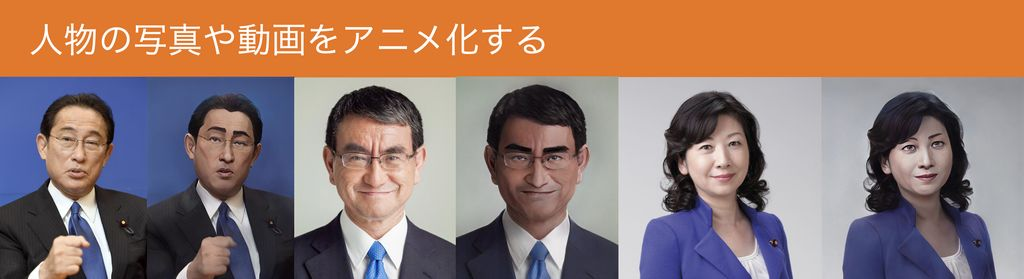*

In [ ]:
#@title 1.インストール
from IPython.utils import io
import os
import subprocess
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:

      ! git clone https://github.com/sugi-san/anime_movie.git
      pbar.update(10)

      ! pip -qq install facenet_pytorch
      pbar.update(30)

      ! pip install gradio encoded-video
      pbar.update(40)

      from moviepy.editor import *
      import torch
      ! wget https://github.com/Sxela/ArcaneGAN/releases/download/v0.4/ArcaneGANv0.4.jit
      model = torch.jit.load('./ArcaneGANv0.4.jit').cuda().eval().half()
      pbar.update(20)

except subprocess.CalledProcessError:
  print(captured)
  raise


# === for picture block ===
from facenet_pytorch import MTCNN
from torchvision import transforms
import torch, PIL
from tqdm.notebook import tqdm

mtcnn = MTCNN(image_size=256, margin=80)

# simplest ye olde trustworthy MTCNN for face detection with landmarks
def detect(img): 
        # Detect faces
        batch_boxes, batch_probs, batch_points = mtcnn.detect(img, landmarks=True)
        # Select faces
        if not mtcnn.keep_all:
            batch_boxes, batch_probs, batch_points = mtcnn.select_boxes(
                batch_boxes, batch_probs, batch_points, img, method=mtcnn.selection_method
            ) 
        return batch_boxes, batch_points

# my version of isOdd, should make a separate repo for it :D
def makeEven(_x):
  return _x if (_x % 2 == 0) else _x+1

# the actual scaler function
def scale(boxes, _img, max_res=1_500_000, target_face=256, fixed_ratio=0, max_upscale=2, VERBOSE=False): 
    x, y = _img.size 
    ratio = 2 #initial ratio
 
    #scale to desired face size
    if (boxes is not None):
      if len(boxes)>0:
        ratio = target_face/max(boxes[0][2:]-boxes[0][:2]); 
        ratio = min(ratio, max_upscale)
        if VERBOSE: print('up by', ratio)

    if fixed_ratio>0:
      if VERBOSE: print('fixed ratio')
      ratio = fixed_ratio
 
    x*=ratio
    y*=ratio
 
    #downscale to fit into max res 
    res = x*y
    if res > max_res:
      ratio = pow(res/max_res,1/2); 
      if VERBOSE: print(ratio)
      x=int(x/ratio)
      y=int(y/ratio)
 
    #make dimensions even, because usually NNs fail on uneven dimensions due skip connection size mismatch
    x = makeEven(int(x))
    y = makeEven(int(y))
    size = (x, y)
    return _img.resize(size)

""" 
    A useful scaler algorithm, based on face detection.
    Takes PIL.Image, returns a uniformly scaled PIL.Image
    boxes: a list of detected bboxes
    _img: PIL.Image
    max_res: maximum pixel area to fit into. Use to stay below the VRAM limits of your GPU.
    target_face: desired face size. Upscale or downscale the whole image to fit the detected face into that dimension.
    fixed_ratio: fixed scale. Ignores the face size, but doesn't ignore the max_res limit.
    max_upscale: maximum upscale ratio. Prevents from scaling images with tiny faces to a blurry mess.
"""

def scale_by_face_size(_img, max_res=1_500_000, target_face=256, fix_ratio=0, max_upscale=2, VERBOSE=False):
    boxes = None
    boxes, _ = detect(_img)
    if VERBOSE: print('boxes',boxes)
    img_resized = scale(boxes, _img, max_res, target_face, fix_ratio, max_upscale, VERBOSE)
    return img_resized


size = 256
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]
t_stds = torch.tensor(stds).cuda().half()[:,None,None]
t_means = torch.tensor(means).cuda().half()[:,None,None]

#def makeEven(_x):
  #return int(_x) if (_x % 2 == 0) else int(_x+1)

img_transforms = transforms.Compose([                        
            transforms.ToTensor(),
            transforms.Normalize(means,stds)])
 
def tensor2im(var):
     return var.mul(t_stds).add(t_means).mul(255.).clamp(0,255).permute(1,2,0)

def proc_pil_img(input_image, model):
    transformed_image = img_transforms(input_image)[None,...].cuda().half()
            
    with torch.no_grad():
        result_image = model(transformed_image)[0]; print(result_image.shape)
        output_image = tensor2im(result_image)
        output_image = output_image.detach().cpu().numpy().astype('uint8')
        output_image = PIL.Image.fromarray(output_image)
    return output_image

#setup colab interface
from google.colab import files
import ipywidgets as widgets
from IPython.display import clear_output 
from IPython.display import display
import os
from glob import glob

in_dir = '/content/in'
out_dir = '/content/out'

def fit(img,maxsize=512):
  maxdim = max(*img.size)
  if maxdim>maxsize:
    ratio = maxsize/maxdim
    x,y = img.size
    size = (int(x*ratio),int(y*ratio)) 
    img = img.resize(size)
  return img
 
def show_img(f, size=1024):
  display(fit(PIL.Image.open(f),size))

def process(upload=False):
  os.makedirs(in_dir, exist_ok=True)
  %cd {in_dir}/
  !rm -rf {out_dir}/*
  os.makedirs(out_dir, exist_ok=True)
  in_files = sorted(glob(f'{in_dir}/*'))
  if (len(in_files)==0) | (upload):
    !rm -rf {in_dir}/*
    uploaded = files.upload()
    if len(uploaded.keys())<=0: 
      print('\nNo files were uploaded. Try again..\n')
      return

  #print('\nPress the button and pick some photos to upload\n')  
  in_files = sorted(glob(f'{in_dir}/*'))
  for img in tqdm(in_files):
    out = f"{out_dir}/{img.split('/')[-1].split('.')[0]}.jpg"
    im = PIL.Image.open(img)
    im = scale_by_face_size(im, target_face=300, max_res=1_500_000, max_upscale=2)
    res = proc_pil_img(im, model)
    res.save(out)

  #out_zip = f"{out_dir}.zip"
  #!zip {out_zip} {out_dir}/*

  processed = sorted(glob(f'{out_dir}/*'))[:3]
  for f in processed: 
    show_img(f, 512)


# === for movie block ===
import gc
import math
import tempfile
from PIL import Image
from io import BytesIO
import torch
import numpy as np
from encoded_video import EncodedVideo, write_video
from torchvision.transforms.functional import to_tensor, center_crop
from torchvision import transforms

means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]
norm = transforms.Normalize(means,stds)

# This function is taken from pytorchvideo!
def uniform_temporal_subsample(x: torch.Tensor, num_samples: int, temporal_dim: int = -3) -> torch.Tensor:
    """
    Uniformly subsamples num_samples indices from the temporal dimension of the video.
    When num_samples is larger than the size of temporal dimension of the video, it
    will sample frames based on nearest neighbor interpolation.
    Args:
        x (torch.Tensor): A video tensor with dimension larger than one with torch
            tensor type includes int, long, float, complex, etc.
        num_samples (int): The number of equispaced samples to be selected
        temporal_dim (int): dimension of temporal to perform temporal subsample.
    Returns:
        An x-like Tensor with subsampled temporal dimension.
    """
    t = x.shape[temporal_dim]
    assert num_samples > 0 and t > 0
    # Sample by nearest neighbor interpolation if num_samples > t.
    indices = torch.linspace(0, t - 1, num_samples)
    indices = torch.clamp(indices, 0, t - 1).long()
    return torch.index_select(x, temporal_dim, indices)

def makeEven(_x):
  return _x if (_x % 2 == 0) else _x+1

def short_side_scale(
    x: torch.Tensor,
    size: int,
    interpolation: str = "bilinear",
) -> torch.Tensor:
    """
    Determines the shorter spatial dim of the video (i.e. width or height) and scales
    it to the given size. To maintain aspect ratio, the longer side is then scaled
    accordingly.
    Args:
        x (torch.Tensor): A video tensor of shape (C, T, H, W) and type torch.float32.
        size (int): The size the shorter side is scaled to.
        interpolation (str): Algorithm used for upsampling,
            options: nearest' | 'linear' | 'bilinear' | 'bicubic' | 'trilinear' | 'area'
    Returns:
        An x-like Tensor with scaled spatial dims.
    """
    assert len(x.shape) == 4
    assert x.dtype == torch.float32
    c, t, h, w = x.shape
    if w < h:
        new_h = int(math.floor((float(h) / w) * size))
        new_w = size
    else:
        new_h = size
        new_w = int(math.floor((float(w) / h) * size))
    return torch.nn.functional.interpolate(
        x, size=(makeEven(new_h), makeEven(new_w)), mode=interpolation, align_corners=False
    )

norms = torch.tensor([0.485, 0.456, 0.406])[None,:,None,None].cuda()
stds = torch.tensor([0.229, 0.224, 0.225])[None,:,None,None].cuda()

def inference_step(vid, start_sec, duration, out_fps, interpolate):
    clip = vid.get_clip(start_sec, start_sec + duration)
    video_arr = torch.from_numpy(clip['video']).permute(3, 0, 1, 2)
    audio_arr = np.expand_dims(clip['audio'], 0)
    audio_fps = None if not vid._has_audio else vid._container.streams.audio[0].sample_rate
    x = uniform_temporal_subsample(video_arr,  duration * out_fps)
    # x = center_crop(short_side_scale(x, 512), 512)
    x = short_side_scale(x, 512)
    x /= 255.
    x = x.permute(1, 0, 2, 3)
    x = norm(x)
    with torch.no_grad():
        output = model(x.to('cuda').half())
        output = (output * stds + norms).clip(0, 1) * 255.
        output_video = output.permute(0, 2, 3, 1).float().detach().cpu().numpy()
        if interpolate == 'Yes': output_video[1:] = output_video[1:]*(0.5) + output_video[:-1]*(0.5)    
    return output_video, audio_arr, out_fps, audio_fps

def predict_fn(filepath, start_sec, duration, out_fps, interpolate):
    vid = EncodedVideo.from_path(filepath)
    for i in tqdm(range(duration)):
        video, audio, fps, audio_fps = inference_step(
            vid = vid,
            start_sec = i + start_sec,
            duration = 1,
            out_fps = out_fps,
            interpolate = interpolate
        )
        gc.collect()
        if i == 0:
            video_all = video
            audio_all = audio
        else:
            video_all = np.concatenate((video_all, video))
            audio_all = np.hstack((audio_all, audio))
    write_video(
        'out.mp4',
        video_all,
        fps=fps,
        audio_array=audio_all,
        audio_fps=audio_fps,
        audio_codec='aac'
    )
    del video_all
    del audio_all    
    return 'out.mp4'

from moviepy.editor import *
def get_duration(file_path):
    clip = VideoFileClip(file_path)
    return int(clip.duration) 

# === other block ===
# 画像表示関数
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np

def display_pic(folder):
    fig = plt.figure(figsize=(20, 40))
    files = os.listdir(folder)
    files.sort()
    for i, file in enumerate(files):
        if file == '.ipynb_checkpoints':
          continue  
        img = Image.open(folder+'/'+file) 
        images = np.asarray(img)
        ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])
        image_plt = np.array(images)
        ax.imshow(image_plt)
        ax.set_xlabel(file, fontsize=20)               
    plt.show()
    plt.close()            

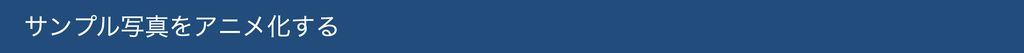

In [ ]:
#@title 2.写真の表示
display_pic('./anime_movie/pic')

In [ ]:
#@title 3.写真のアニメ化
import os
import shutil
import cv2

# カレントディレクトリを/contentに
%cd /content

# inフォルダーリセット
if os.path.isdir('/content/in'):
    shutil.rmtree('/content/in')
os.makedirs('/content/in', exist_ok=True)

# 指定画像をinフォルダーへコピー
input = 'kishida.jpg'#@param {type:"string"}
shutil.copy('/content/anime_movie/pic/'+input, '/content/in/'+input)

# 写真のアニメ化
process()

# カレントディレクトリをcontentに
%cd /content

In [ ]:
#@title 4.アニメのダウンロード
from google.colab import files
files.download('/content/out/'+input)

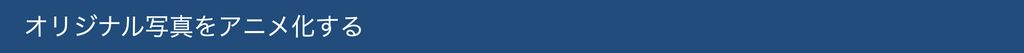

In [ ]:
#@title 5.写真のアップロード
# アップロード時にサイズ調整をしてpicフォルダへ
import os
import shutil
from google.colab import files
import cv2

# ルートへ画像をアップロード
uploaded = files.upload()           
uploaded = list(uploaded.keys())    

# ルートからpicフォルダーへ移動
for file in uploaded:
    #size_opt(file)  # サイズ調整して上書き
    img = cv2.imread(filename = file, flags = cv2.IMREAD_COLOR)  # 上書きしたものを再読み込み
    shutil.move(file, './anime_movie/pic/'+file)  # 移動

display_pic('./anime_movie/pic')

In [ ]:
#@title 6.写真をアニメに変換
import os
import shutil
import cv2

# カレントディレクトリを/contentに
%cd /content

# inフォルダーリセット
if os.path.isdir('/content/in'):
    shutil.rmtree('/content/in')
os.makedirs('/content/in', exist_ok=True)

# 指定画像をinフォルダーへコピー
input = ''#@param {type:"string"}
shutil.copy('/content/anime_movie/pic/'+input, '/content/in/'+input)

# 写真のアニメ化
process()

# カレントディレクトリをcontentに
%cd /content

In [ ]:
#@title 7.アニメのダウンロード
from google.colab import files
files.download('/content/out/'+input)

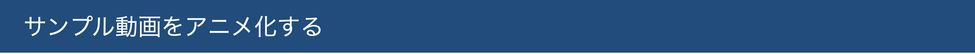

In [ ]:
#@title 8.動画リストの表示
import os
files = sorted(os.listdir('/content/anime_movie/movies'))
for file in files:
   print(file)


In [ ]:
#@title 9.動画のアニメ化
movie = 'abe.mp4'#@param {type:"string"}
#@markdown ・動画は30秒以内、5MB以下を目安にして下さい
movie_path = '/content/anime_movie/movies/'+movie
duration = get_duration(movie_path)
out_fps = 30 #param {type:"slider", min:12, max:30, step:6}
predict_fn(movie_path, 0, duration, out_fps, 'yes')

# 動画の再生
from IPython.display import HTML
from base64 import b64encode
mp4 = open('./out.mp4', 'rb').read()
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
HTML(f"""
<video width="70%" height="70%" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")

In [ ]:
#@title 10.アニメ動画のダウンロード
import shutil
from google.colab import files
shutil.copy('out.mp4', movie)
files.download(movie)

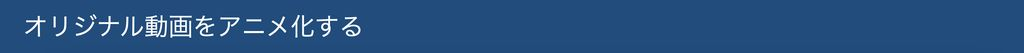

In [ ]:
#@title 11.動画のアップロード
import os
import shutil
from google.colab import files
import cv2

# ルートへ画像をアップロード
uploaded = files.upload()           
uploaded = list(uploaded.keys())    

# ルートからpicフォルダーへ移動
for file in uploaded:
    #size_opt(file)  # サイズ調整して上書き
    #img = cv2.imread(filename = file, flags = cv2.IMREAD_COLOR)  # 上書きしたものを再読み込み
    shutil.move(file, './anime_movie/movies/'+file)  # 移動

# 動画リストの表示
print()
files = sorted(os.listdir('/content/anime_movie/movies'))
for file in files:
   print(file)

In [ ]:
#@title 12.動画のアニメ化
movie = ''#@param {type:"string"}
#@markdown ・動画は30秒以内、5MB以下を目安にして下さい
movie_path = '/content/anime_movie/movies/'+movie
duration = get_duration(movie_path)
out_fps = 30 #param {type:"slider", min:12, max:30, step:6}
predict_fn(movie_path, 0, duration, out_fps, 'yes')

# 動画の再生
from IPython.display import HTML
from base64 import b64encode
mp4 = open('./out.mp4', 'rb').read()
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
HTML(f"""
<video width="70%" height="70%" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")

In [ ]:
#@title 13.アニメ動画のダウンロード
import shutil
from google.colab import files
shutil.copy('out.mp4', movie)
files.download(movie)

###【備考】
・ブラウザは、必ずGoogle Chromeを使用して下さい。

・動作がおかしくなった場合の対応\
１）グーグルクロームの該当タブを削除して接続を切る\
２）再度リンクを開く\
３）右上にある「ランタイム／ランタイムを出荷時設定にリセット」をクリックする（下記写真を参照に下さい）\
４）あとは、動画にある通りの操作をすればOK

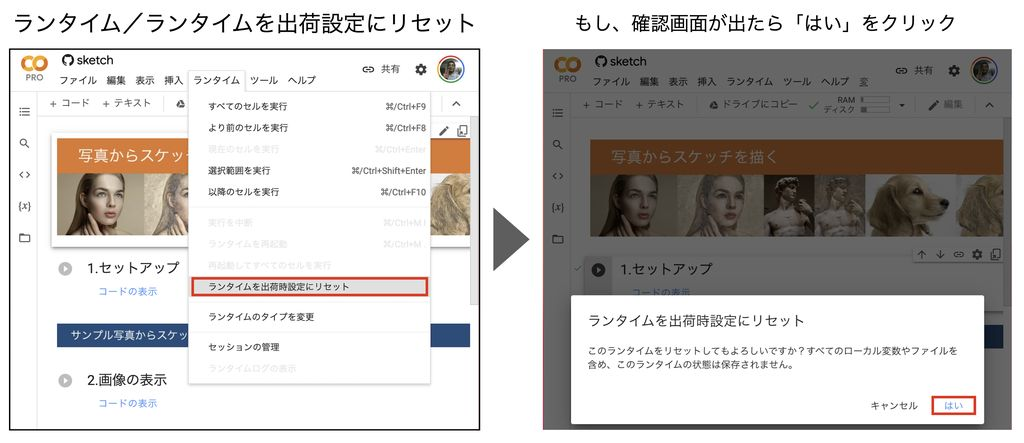